In [2]:
# Import required libraries
import os
import requests
import tarfile

# Define the URL for the SVHN dataset
data_url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
test_data_url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'

# Download the data
def download_svhn_data(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

# Download training and test data
download_svhn_data(data_url, 'train_32x32.mat')
download_svhn_data(test_data_url, 'test_32x32.mat')


In [3]:
# Import libraries to load SVHN data
import scipy.io as sio
import numpy as np

# Load training data
train_data = sio.loadmat('train_32x32.mat')
X_train = train_data['X']
y_train = train_data['y']

# Load test data
test_data = sio.loadmat('test_32x32.mat')
X_test = test_data['X']
y_test = test_data['y']

# Reshape data to fit Keras format
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

# Convert labels to categorical format
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
def augment_data(X_train, y_train):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=False
    )
    datagen.fit(X_train)
    return datagen

datagen = augment_data(X_train, y_train)


In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [6]:
from tensorflow.keras import layers, models

def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

cnn_model = create_cnn_model()
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


916/916 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2307 - loss: 2.7251 - val_accuracy: 0.7617 - val_loss: 0.8266
Epoch 2/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.6019 - loss: 1.2361 - val_accuracy: 0.8400 - val_loss: 0.5515
Epoch 3/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.7090 - loss: 0.9328 - val_accuracy: 0.8528 - val_loss: 0.4943
Epoch 4/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.7429 - loss: 0.8326 - val_accuracy: 0.8793 - val_loss: 0.4219
Epoch 5/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.7675 - loss: 0.7641 - val_accuracy: 0.8815 - val_loss: 0.4107
Epoch 6/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.7827 - loss: 0.7097 - val_accuracy: 0.8830 - val_loss: 0.4063
Epoch 7/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.7919 - loss: 0.6809 - val_accuracy: 0.8946 - val_loss: 0.3708
Epoch 8/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.8004 - loss: 0.6587 - val_accurac

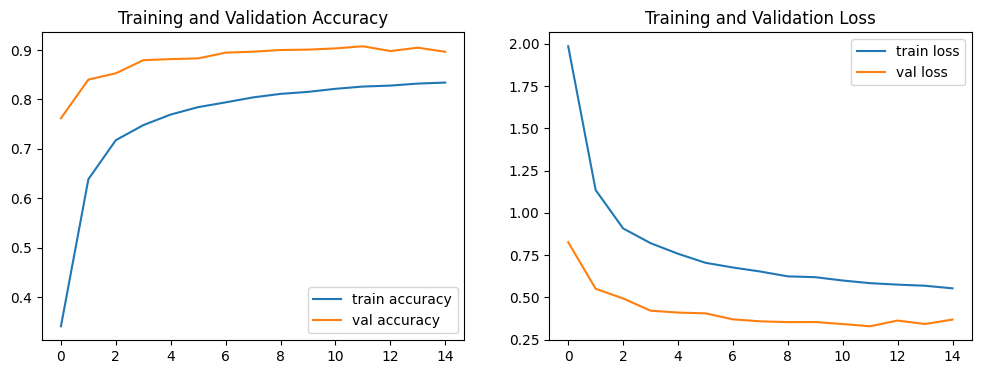

In [7]:
import matplotlib.pyplot as plt

def train_model(model, datagen, X_train, y_train, X_val, y_val, epochs=5, batch_size=64):
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        verbose=1)

    # Plot training & validation accuracy and loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

    return model

# Train the model
cnn_model = train_model(cnn_model, datagen, X_train, y_train, X_val, y_val, epochs=15)


814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9020 - loss: 0.3627
Test accuracy: 0.9058082103729248
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1744
           1       0.93      0.96      0.94      5099
           2       0.94      0.93      0.94      4149
           3       0.83      0.89      0.86      2882
           4       0.95      0.91      0.93      2523
           5       0.83      0.93      0.88      2384
           6       0.92      0.81      0.86      1977
           7       0.95      0.86      0.90      2019
           8       0.91      0.82      0.86      1660
           9       0.86      0.90      0.88      1595

    accuracy                           0.91     26032
   macro avg       0.90      0.89      0.90     26032
weighted avg       0.91      0.91      0.91     26032



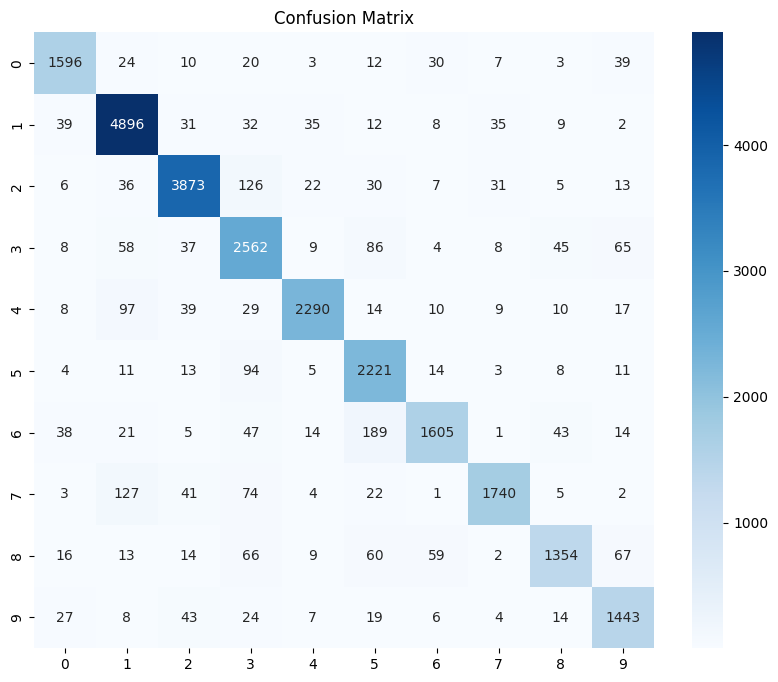

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

# Generate predictions
y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Plot the precision-recall curve
plot_precision_recall(y_true, y_pred)


ValueError: multiclass format is not supported